In [1]:
import os ; import sys
sys.path.append(os.getcwd()+"/../../src")
sys.path.append(os.environ["PYQULAROOT"])

from qtcipy import interpolate

# Selfconsistent calculations with KPM QTCI


## Algorithm
The next cell defines the functions required for the algorithm

In [2]:
# you do not have to modify this cell

import numpy as np


def memoize(func):
    """Decorator to use a cache"""
    cache = {}
    
    def memoized_func(*args):
        if args in cache:
            return cache[args]
        result = func(*args)
        cache[args] = result
        return result
    
    return memoized_func


def get_density_i(m,fermi=0.,i=0,delta=1e-1):
    """Return electronic density at site i"""
    ne = int(100/delta) # number of energies
    scale = 10.0 # scale of KPM method
#    delta = 0.1 # effective smearing
    from pyqula import kpm
    (es,ds) = kpm.ldos(m,i=i,ne=ne,npol=5*int(scale/delta)) # compute the LDOS with KPM
#    print(ds).real
    ds = ds.real # just the real part
    return np.trapz(ds[es<fermi])/np.trapz(ds) # return filling of the site


def get_den_ed(h,fermi=0.,**kwargs):
    """Return the total electronic density using exact diagonalization"""
    from scipy.linalg import eigh
    if h.shape[0]>10000: raise # sanity check
    (es,ws) = eigh(h.todense()) # diagonalize
    ws = ws.T # wavefucntions as rows
    out = 0. # initialize
    for i in range(len(es)):
        if es[i]<fermi: out += np.abs(ws[i])**2 # add contribution
    return out


def get_den_kpm(h,use_qtci=True,info_qtci=False,**kwargs):
    """Return the electronic density of the system uisng KPM and QTCI"""
    @memoize
    def f(i): # function to interpolate
        return get_density_i(h,i=int(i),**kwargs)
    if use_qtci: # use quantics tensor corss interpolation
        xlim = [0,h.shape[0]] # limits of the interpolation
        nb = 5
        nb = np.log(h.shape[0])/np.log(2)
        if np.abs(int(nb)-nb)>1e-5:
            pritn("Number of points must be a power of 2")
            raise
        nb = int(nb) # number of points
        IP = interpolate.Interpolator(f,tol=1e-3,nb=nb,xlim=xlim,dim=1)
        rse,zse = IP.get_evaluated()
        if info_qtci:
             print(len(rse)/h.shape[0],"ratio of evaluations") 
        return np.array([IP(float(i)) for i in range(0,h.shape[0])])
    else: # brute force
        return np.array([f(i) for i in range(0,h.shape[0])])


def get_den(h,use_kpm=False,**kwargs):
    if use_kpm: return get_den_kpm(h,**kwargs) # compute using the KPM
    else: return get_den_ed(h,**kwargs) # compute using the KPM


def SCF_Hubbard(h0,U=0.,dup=None,ddn=None,maxerror=1e-3,maxite=None,
                mix=0.3,info=False,**kwargs):
    """
    Perform a selfconsistent Hubbard calculation
       - h0 is the single particle Hamiltonian
       - U is the Hubbard interaction
       - dup is the initial guess for the up density
       - ddn is the initial guess for the dn density
       - maxerror is the maximum error of the selfconsistent loop
       - mix mixes the mean field, for stability
       """
    ddn_old = ddn.copy() # make a copy
    dup_old = dup.copy() # make a copy
    from scipy.sparse import diags
    ite = 0
    while True: # infinite loop
        ite += 1
        hup = h0 + U*diags(ddn_old-0.5,shape=h0.shape) # up Hamiltonian
        hdn = h0 + U*diags(dup_old-0.5,shape=h0.shape) # down Hamiltonian
        ddn = get_den(hdn,**kwargs) # generate down density
        dup = get_den(hup,**kwargs) # generate up density
        error = np.mean(np.abs(ddn-ddn_old) + np.abs(dup-dup_old)) # error
        if info: print("Error",error)
        if error<maxerror: break # stop loop
        if maxite is not None:
            if ite>maxite: break
        dup_old = mix*dup_old + (1.-mix)*dup # update
        ddn_old = mix*ddn_old + (1.-mix)*ddn # update
    return hup,hdn,dup,ddn # return Hamiltonian and densities




# One-dimensional chain
Let us now test the algorithm with a one-dimensional chain

In [8]:
# define a first neighbor tight binding model
L = 6 # exponential length
n = 2**L # number of sites
rows,cols = np.array(range(0,n-1)),np.array(range(1,n)) # indexes
data = np.array([1. for i in range(n-1)],dtype=np.complex128) # hopping 1 for all
k = 0.2/np.sqrt(2)
data = 1. + 0.2*np.cos(np.pi*2.*k*(rows+cols)/2.)*data

from scipy.sparse import csc_matrix
h0 = csc_matrix((data,(rows,cols)),shape=(n,n),dtype=np.complex128) # create single particle hopping
h0 = h0 + h0.T # add the transpose

get_density_i(h0,delta=1e-1)

/tmp/ipykernel_1227649/219936788.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(ds[es<fermi])/np.trapz(ds) # return filling of the site


np.float64(0.497885078873386)

### Mean-field calculation with ED
As a reference, lets first perform the ED calculation

Error 1.3125
Error 0.10671689825099603
Error 0.038908043383251906
Error 0.024825359789467
Error 0.020012014616076542
Error 0.0161150040833446
Error 0.01276203417634241
Error 0.00998227229654735
Error 0.007736137441723004
Error 0.005954056732931567
Error 0.004558749693506567
Error 0.0034768204155488534
Error 0.002643878714009267
Error 0.0020060327042033784
Error 0.0015195261670439327
Error 0.001149556246449403
Error 0.0008688375841885273


Text(0.5, 0, 'Site index')

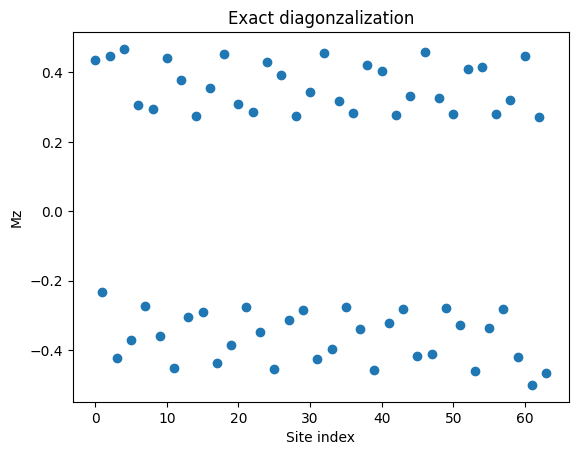

In [6]:
# perform a mean-field calculation using ED

dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

hup_ed,hdn_ed,dup_ed,ddn_ed = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=False,info=True,U=2.)

import matplotlib.pyplot as plt

plt.title("Exact diagonzalization")
plt.scatter(range(len(dup_ed)),dup_ed-ddn_ed)
plt.ylabel("Mz") ; plt.xlabel("Site index")

# perform a mean-field calculation using KPM (just as a reference)

dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

hup_kpm,hdn_kpm,dup_kpm,ddn_kpm = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=True,use_qtci=False,
                              info=True,U=2.,delta=.2)

import matplotlib.pyplot as plt


plt.scatter(range(len(dup_kpm)),dup_kpm-ddn_kpm)

/home/joselado/apps/anaconda3/lib/python3.11/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.3+0.x64.linux.gnu. You currently have `1.10.4+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.linux.gnu and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/tmp/ipykernel_1227649/219936788.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(ds[es<fermi])/np.trapz(ds) # return filling of the site


Error 1.3122176154359295
Error 0.10658572299110271
Error 0.03890879788010747
Error 0.024786733195168675
Error 0.01996245477658945
Error 0.016077125519550886
Error 0.012735686014522093
Error 0.009964692122506495
Error 0.00772478157051626
Error 0.005947022205726982
Error 0.004554631089299803
Error 0.003474623611858632
Error 0.0026429121217325874
Error 0.002005824171038971
Error 0.0015197620616993548
Error 0.0011500315322428645
Error 0.0008694159139369141
Time 39.610438108444214


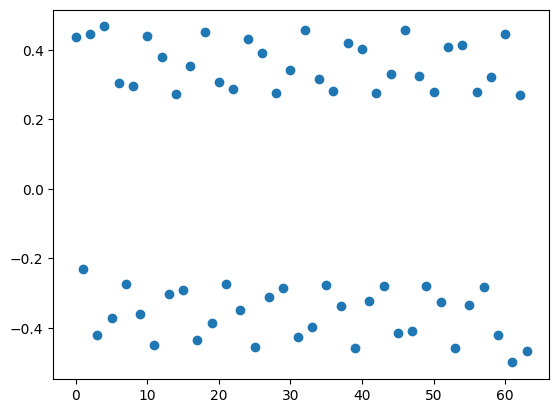

In [7]:
# perform a mean-field calculation using KPM and QTCI

dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize
import time

t0 = time.time()
hup,hdn,dup,ddn = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=True,use_qtci=True,
                              info=True,U=2.,delta=.1)
t1 = time.time()

print("Time",t1-t0)

import matplotlib.pyplot as plt


plt.scatter(range(len(dup)),dup-ddn)

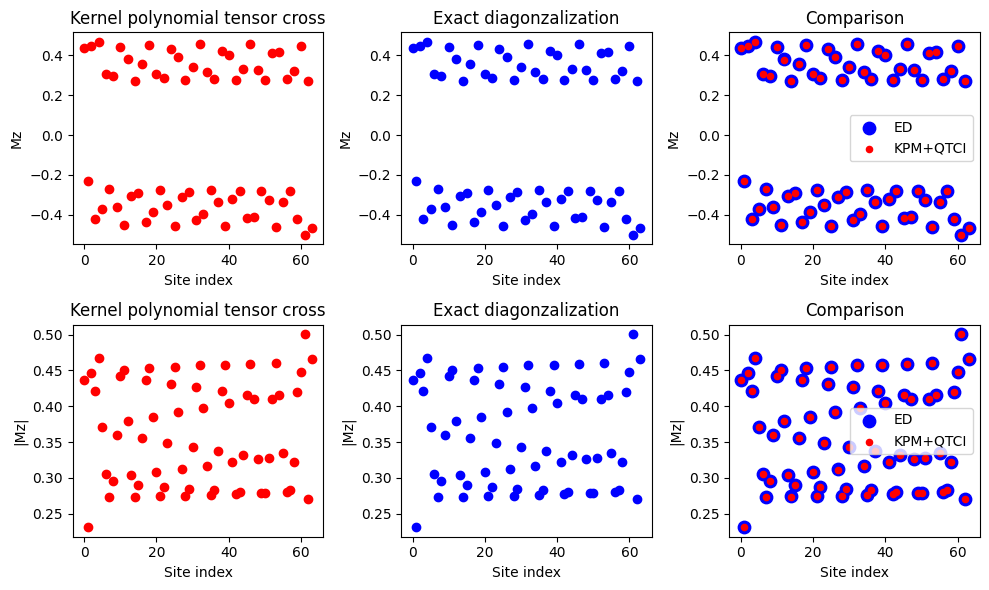

In [10]:
fig = plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.title("Kernel polynomial tensor cross")
plt.scatter(range(len(dup)),dup-ddn,label="KPM+QTCI",c="red")
plt.ylabel("Mz") ; plt.xlabel("Site index")

plt.subplot(2,3,2)
plt.title("Exact diagonzalization")
plt.scatter(range(len(dup_ed)),dup_ed-ddn_ed,c="blue")
plt.ylabel("Mz") ; plt.xlabel("Site index")

plt.subplot(2,3,3)
plt.title("Comparison")
plt.scatter(range(len(dup_ed)),dup_ed-ddn_ed,label="ED",s=80,c="blue")
plt.scatter(range(len(dup)),dup-ddn,label="KPM+QTCI",s=20,c="red")
plt.legend()
plt.ylabel("Mz") ; plt.xlabel("Site index")

# now absolute
plt.subplot(2,3,4)
plt.title("Kernel polynomial tensor cross")
plt.scatter(range(len(dup)),np.abs(dup-ddn),label="KPM+QTCI",c="red")
plt.ylabel("|Mz|") ; plt.xlabel("Site index")

plt.subplot(2,3,5)
plt.title("Exact diagonzalization")
plt.scatter(range(len(dup_ed)),np.abs(dup_ed-ddn_ed),c="blue")
plt.ylabel("|Mz|") ; plt.xlabel("Site index")

plt.subplot(2,3,6)
plt.title("Comparison")
plt.scatter(range(len(dup_ed)),np.abs(dup_ed-ddn_ed),label="ED",s=80,c="blue")
plt.scatter(range(len(dup)),np.abs(dup-ddn),label="KPM+QTCI",s=20,c="red")
plt.legend()
plt.ylabel("|Mz|") ; plt.xlabel("Site index")



plt.tight_layout()

16384 Sites
0.0469970703125 ratio of evaluations
0.056884765625 ratio of evaluations
Error 1.303150180429435
0.04632568359375 ratio of evaluations
0.04925537109375 ratio of evaluations
Error 0.08802064404352865
0.0467529296875 ratio of evaluations
0.05010986328125 ratio of evaluations
Error 0.026206874678966763
0.0416259765625 ratio of evaluations
0.044921875 ratio of evaluations
Error 0.018697462804157024
0.04705810546875 ratio of evaluations
0.0408935546875 ratio of evaluations
Error 0.015259506190581914
0.0533447265625 ratio of evaluations
0.06134033203125 ratio of evaluations
Error 0.012303248800582348
0.0546875 ratio of evaluations
0.05804443359375 ratio of evaluations
Error 0.009821754613556586
0.05023193359375 ratio of evaluations
0.05828857421875 ratio of evaluations
Error 0.007786474123472981
0.04595947265625 ratio of evaluations
0.068603515625 ratio of evaluations
Error 0.006137655598770748
0.04730224609375 ratio of evaluations
0.06182861328125 ratio of evaluations
Error 0.00

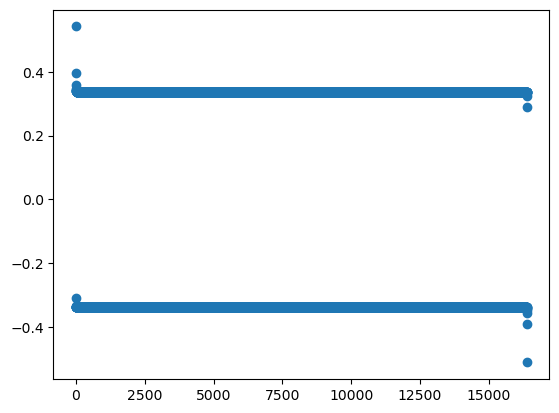

In [7]:
# define a first neighbor tight binding model
L = 14 # exponential length
n = 2**L # number of sites
rows,cols = np.array(range(0,n-1)),np.array(range(1,n)) # indexes
data = np.array([1. for i in range(n-1)]) # hopping 1 for all
from scipy.sparse import csc_matrix
h0 = csc_matrix((data,(rows,cols)),shape=(n,n)) # create single particle hopping
h0 = h0 + h0.T # add the transpose

print(h0.shape[0],"Sites")

# perform a mean-field calculation using KPM and QTCI


dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

use_kpm,use_qtci = True,True
#use_kpm,use_qtci = False,False

hup,hdn,dup,ddn = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=use_kpm,use_qtci=use_qtci,
                              info=True,info_qtci=True,U=2.,delta=0.2)

import matplotlib.pyplot as plt


plt.scatter(range(len(dup)),dup-ddn)

Text(0.5, 0, 'Site index')

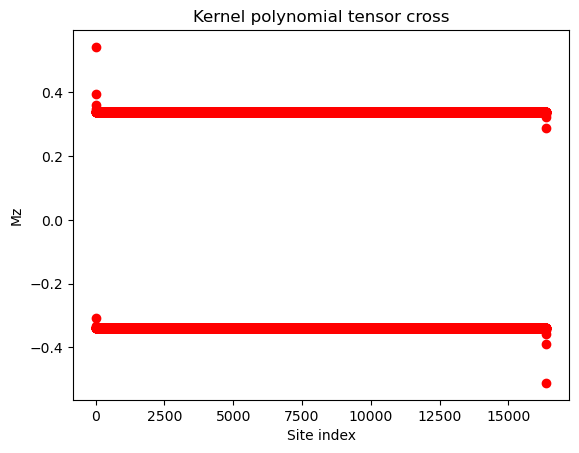

In [8]:
plt.title("Kernel polynomial tensor cross")
plt.scatter(range(len(dup)),dup-ddn,label="KPM+QTCI",c="red")
plt.ylabel("Mz") ; plt.xlabel("Site index")

# Timing
Check the timing of the function

In [109]:
def get_time(L,use_kpm=True,use_qtci=True):
#    L = 6 # exponential length
    n = 2**L # number of sites
    rows,cols = np.array(range(0,n-1)),np.array(range(1,n)) # indexes
    data = np.array([1. for i in range(n-1)],dtype=np.complex_) # hopping 1 for all
    k = 0.2/np.sqrt(2)
    data = 1. + 0.2*np.cos(np.pi*2.*k*(rows+cols)/2.)*data

    from scipy.sparse import csc_matrix
    h0 = csc_matrix((data,(rows,cols)),shape=(n,n),dtype=np.complex_) # create single particle hopping
    h0 = h0 + h0.T # add the transpose

    get_density_i(h0,delta=1e-1)
    dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
    ddn0 = -dup0 # initialize
    import time

    t0 = time.time()
    hup,hdn,dup,ddn = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=use_kpm,use_qtci=use_qtci,
                              info=True,U=2.,delta=.1,maxite=1)
    t1 = time.time()
    return t1-t0

Ls = range(2,12)
#ts = [get_time(L) for L in Ls] # time with QTCI
ts_kpm = [get_time(L,use_kpm=True,use_qtci=False) for L in Ls] # time with ED
#ts_ed = [get_time(L,use_kpm=False) for L in Ls] # time with ED

Error 1.4999442238079475
Error 0.25477430524428013
Error 1.2507188532586464
Error 0.17892134656924727
Error 1.328794176024175
Error 0.11898415500269907
Error 1.3135248438839038
Error 0.12119443687724907
Error 1.3122176246764736
Error 0.10658572380057657
Error 1.3101522034403517
Error 0.10295782874506797
Error 1.3090675992927356
Error 0.10095423128087114
Error 1.308797500542215
Error 0.10063554926586804
Error 1.3087728827715317
Error 0.10014943333994637
Error 1.3086159843480898
Error 0.09987004752339568


Text(0, 0.5, 'log [Time]')

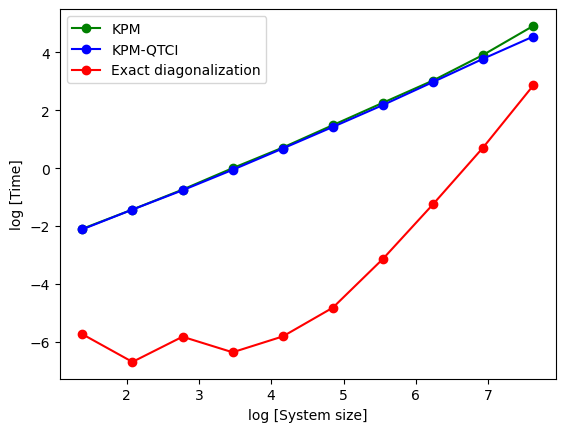

In [112]:
plt.plot(np.log(2**np.array(Ls)),np.log(ts_kpm),marker="o",label="KPM",c="green")
plt.plot(np.log(2**np.array(Ls)),np.log(ts[0:len(Ls)]),marker="o",label="KPM-QTCI",c="blue")
plt.plot(np.log(2**np.array(Ls)),np.log(ts_ed[0:len(Ls)]),marker="o",label="Exact diagonalization",c="red")
plt.legend()
plt.xlabel("log [System size]") ; plt.ylabel("log [Time]")